In [1]:
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = '14'
plt.rcParams['figure.dpi'] = 125
plt.rcParams['figure.facecolor'] = 'white'

import numpy as np

import obspy
from obspy import read, UTCDateTime, Stream, Trace

import xarray as xr
import pandas as pd
from tqdm import tqdm

import scipy
from scipy.signal import spectrogram as sp
from scipy.signal import welch 

import os
import sys  

from pypekeris import pekeris, pekeris_broadband
# module_path = os.path.abspath(os.path.join('/Users/gilaverbuch/dev/WavePropagation/pypekeris'))
# if module_path not in sys.path:
#     sys.path.append(module_path)
# from src.pypekeris.pypekeris import pekeris, pekeris_broadband


# Problem geometry

Two-layer liquid half space. Layer 1 (0<z<D) has a speed of sound c1. Layer 2 (z>D) has a speed of sound c2. Both source and receiver ar placed within the first layer. c2>c1. 

--------------------------------------------------------------------------------- z=0, pressure release surface

c1


*(0, z_s)




                                                           *(r,z)

--------------------------------------------------------------------------------- z=D, continuitu of P and w

c2



The period equation $\cot (k_0 \mu_1 d)$ = $-|\mu_2|/\mu_1$ -> Discrete spectrum. It implicitly defines the relationship between the priod and phase velocity.

In [2]:
P = pekeris()
P._calc_parameters()
P._print_parameters()

zs 10
zr 10
r 5000
dr 10
c0 1500
c1 1500
c2 2000
d 50
dz 1
freq 50
nq 1000.0
omega 314.1592653589793
k0 0.20943951023931956
k1 1.0
k2 0.75
dq 0.00025


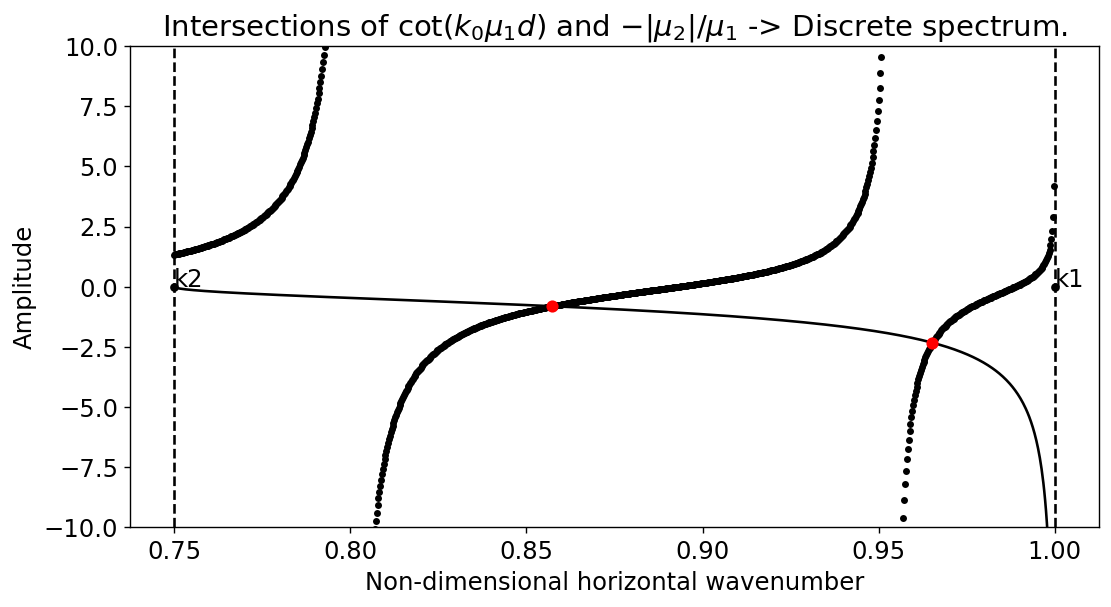

In [3]:
P._plot_discrete_modes()

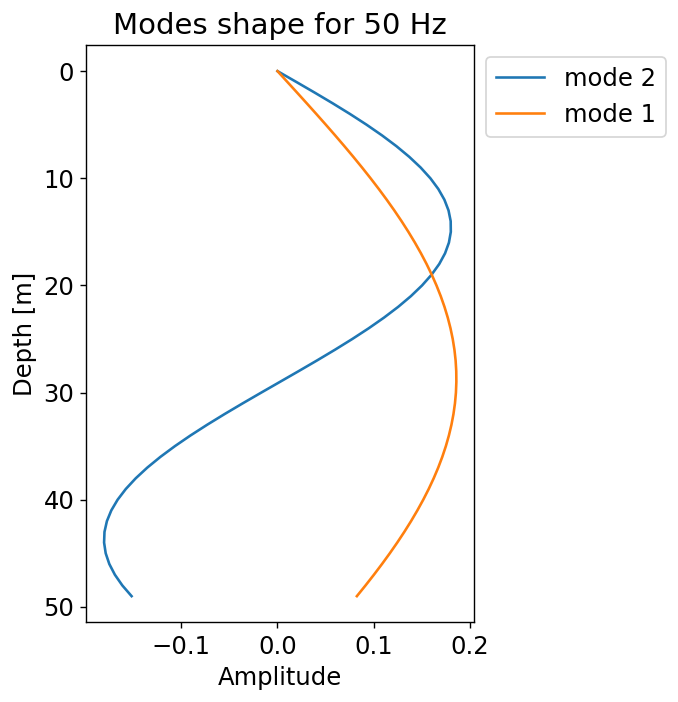

In [4]:
P._plot_modes_shape()

/Users/gilaverbuch/dev/miniconda3/envs/pypekeris/lib/python3.11/site-packages/pypekeris/core/core.py:226: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(self._r, self._z, 20*np.log10(np.abs(self.Phi_2D)/np.abs(p_ref)))


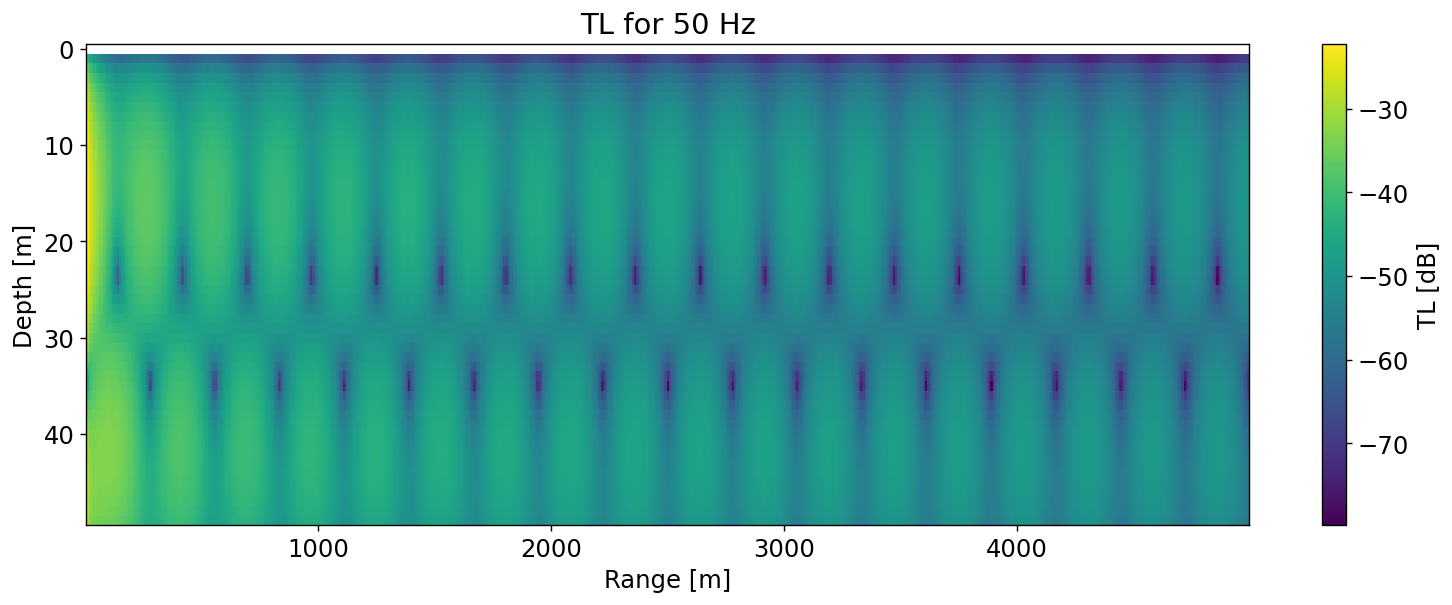

In [5]:
P._calc_2D_field()
P._plot_TL()

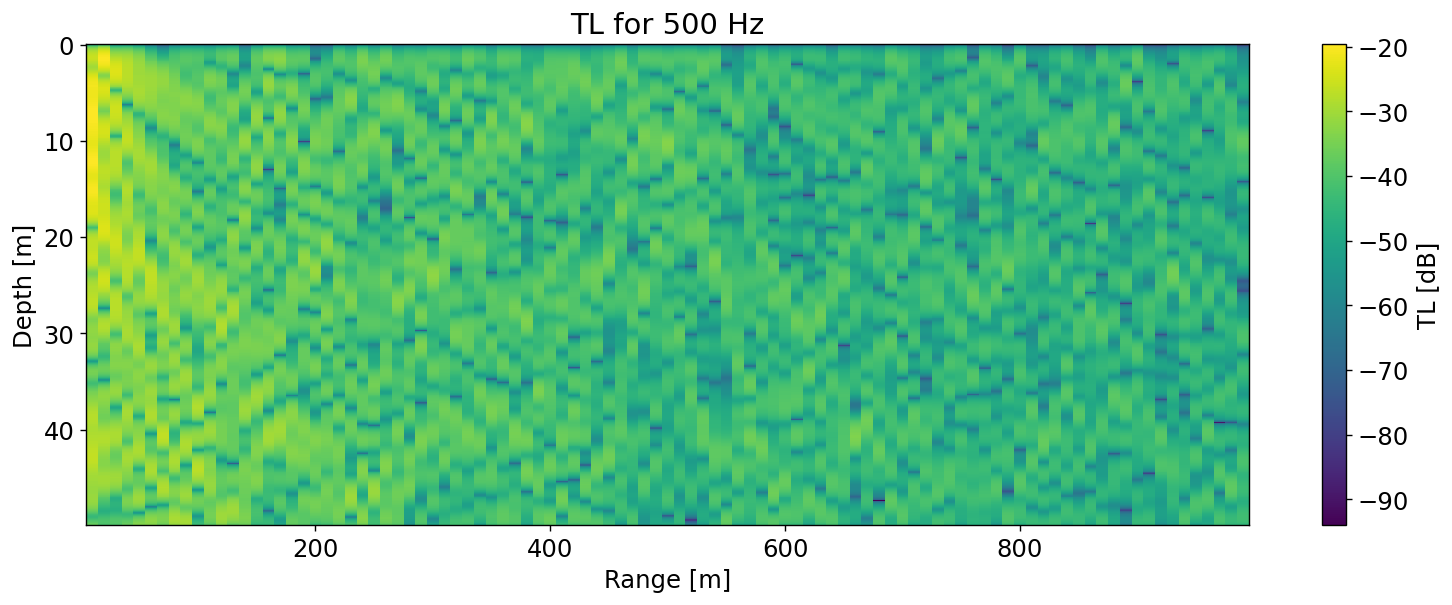

In [6]:
P.freq = 500
P.dz = 0.1
P.r = 1000
P._calc_parameters()
P._calc_2D_field()
P._plot_TL()

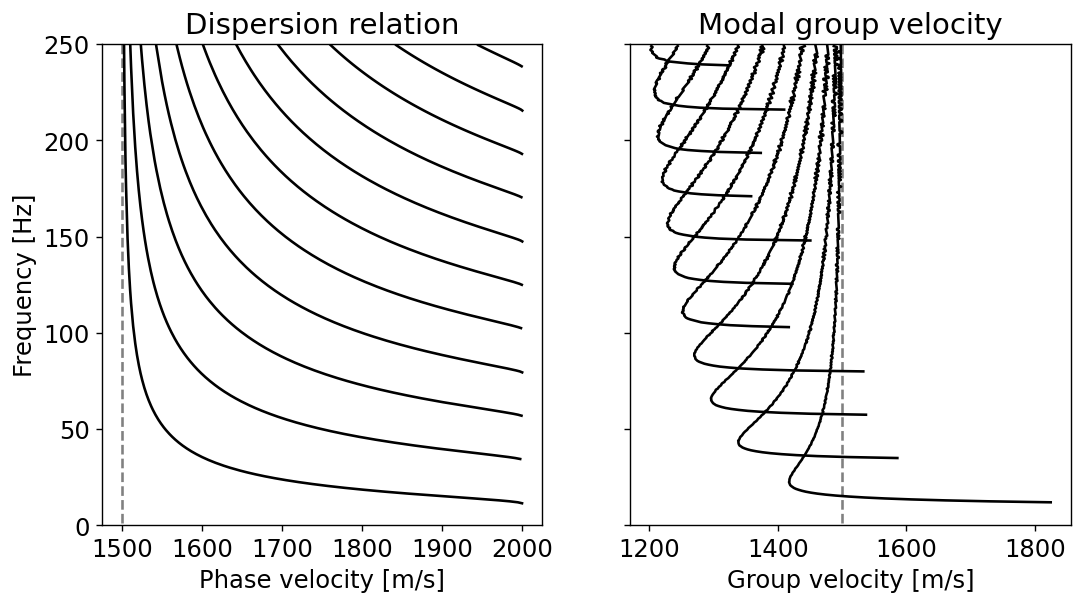

In [7]:
P.nq=2e4
P._calc_parameters()
P._plot_dispersion(fmax=250, df=0.1)

In [8]:
%%time
tr_s, tr_r = pekeris_broadband(fmax=4.9e2, r=2e4, dt=1e-3, num_mode=5)

100%|███████████████████████████████████| 24749/24749 [00:24<00:00, 1006.25it/s]

CPU times: user 19 s, sys: 5.78 s, total: 24.8 s
Wall time: 25 s


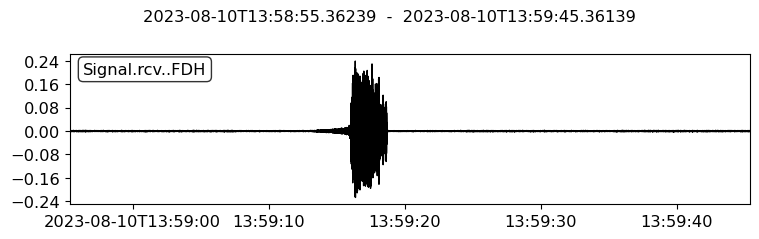

In [9]:
tr_r.plot();

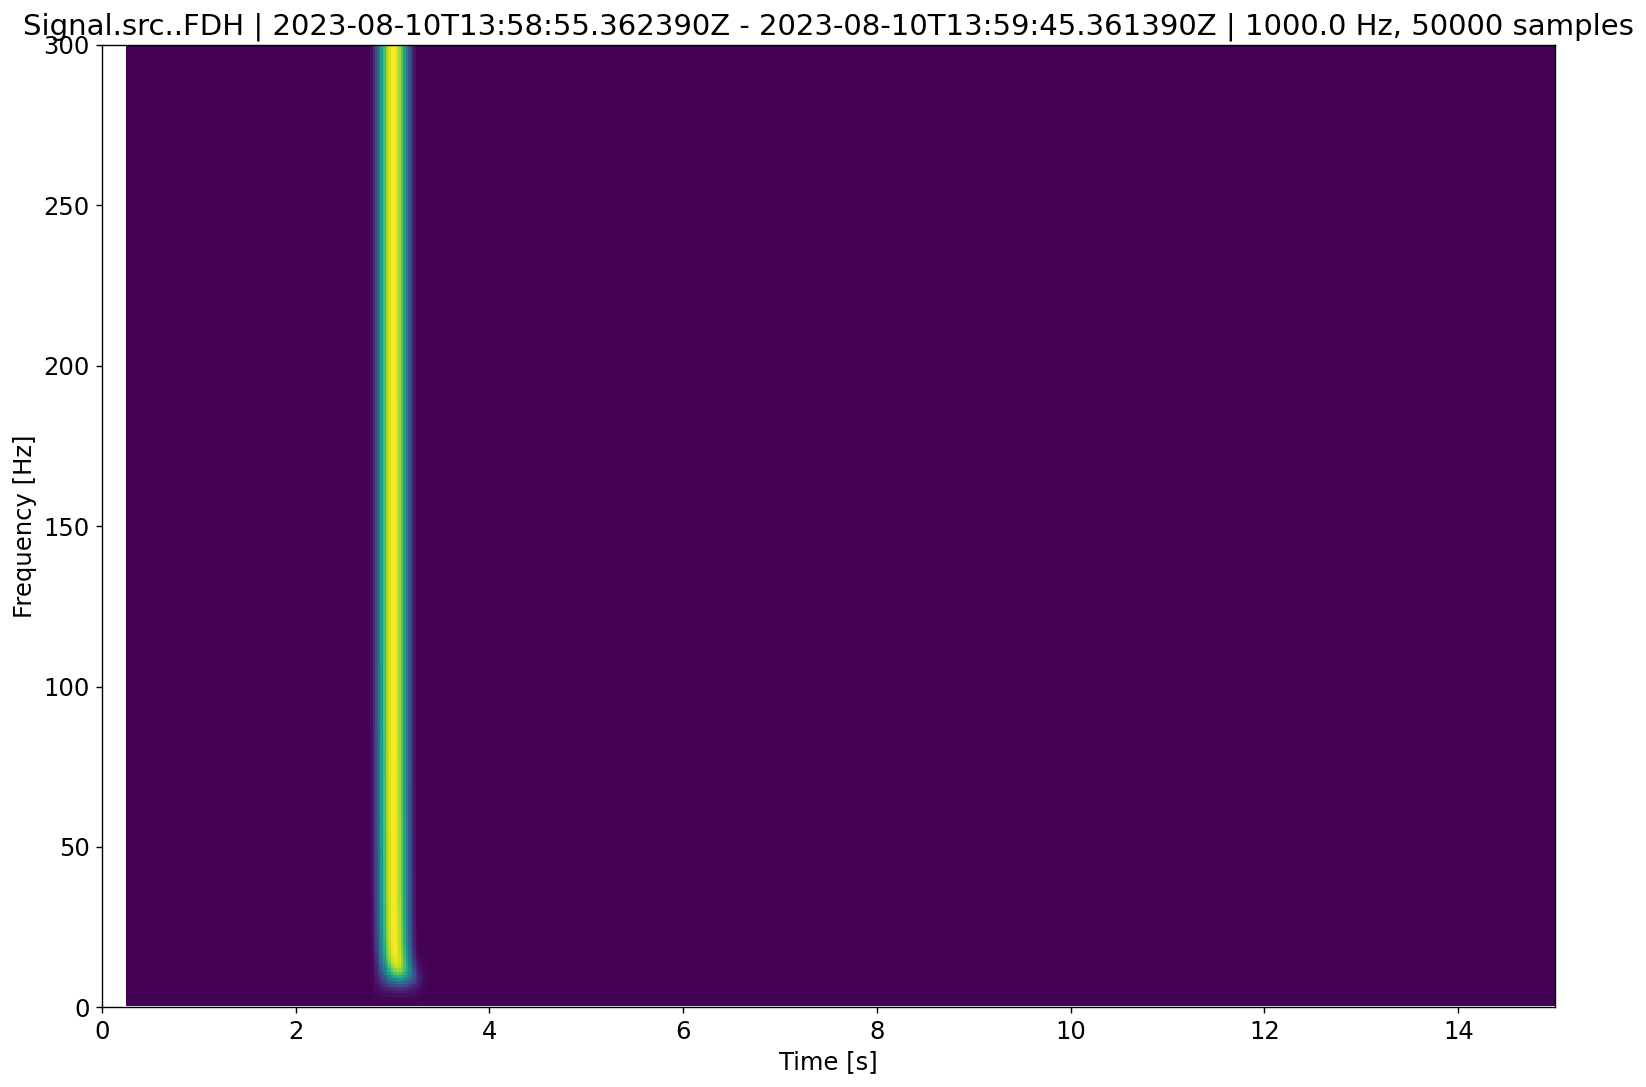

In [10]:
fig = tr_s.spectrogram(wlen=0.5, per_lap=0.95, mult=2, log=False, dbscale=False, show=False);
fig.set_figheight(10)
fig.set_figwidth(15)
plt.ylim(0,300)
plt.xlim(0,15)
plt.show()

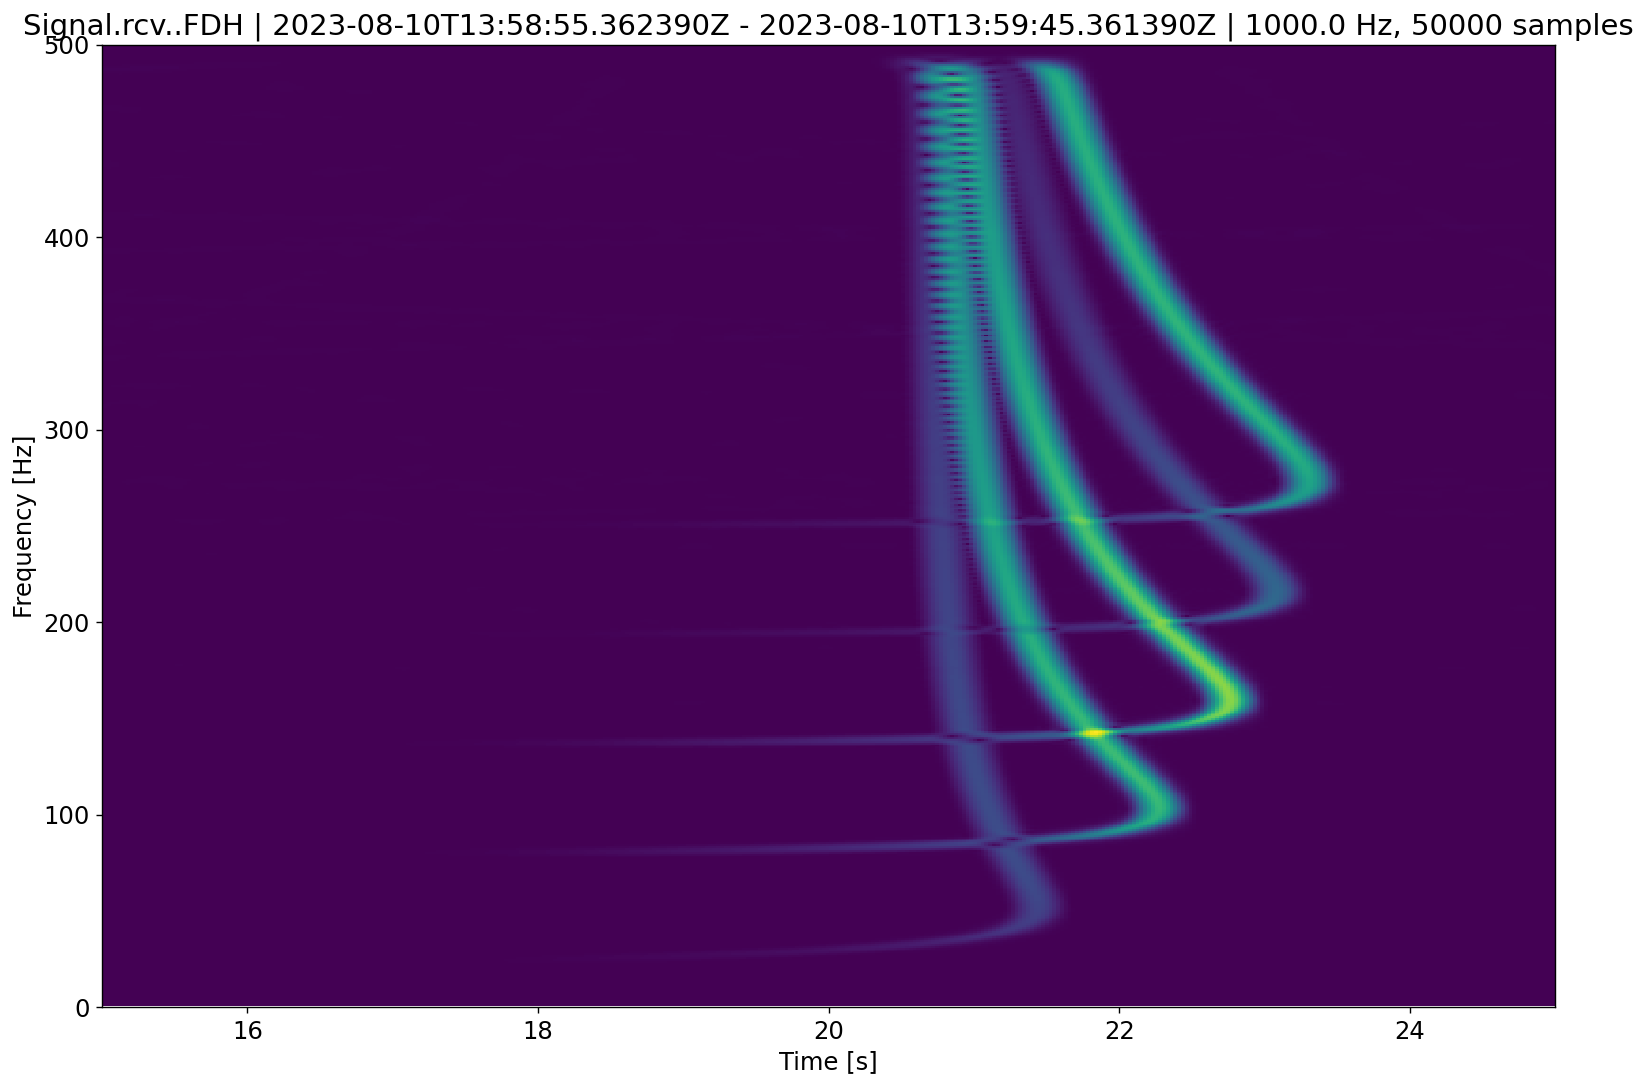

In [14]:
fig = tr_r.spectrogram(wlen=0.5, per_lap=0.95, mult=2, log=False, dbscale=False, show=False);
fig.set_figheight(10)
fig.set_figwidth(15)
plt.ylim(0,500)
plt.xlim(15,25)
plt.show()